In [34]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt
#import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
e = 1e-3
np.sqrt(1- np.exp(-20*e))

0.14071718691490656

In [36]:
config = get_config()

#data = np.load(config.data_path, allow_pickle=True).flatten()

#n = (plt.hist(data, bins=200, density=True))
#100*(n[0][(np.abs(n[1])>1.5)[:-1]].sum()/n[0].sum())

In [37]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
config = get_config()
scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
            *config.model_parameters)
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "EE" in file:
        print(file)
        entered = True
        scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
sd = scoreModel.state_dict()
for name, tensor in sd.items():
    if "hybrid" in name:
        print(name, tensor.shape)
        print(tensor)

trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110_EENEp550
mlp_state_mapper.hybrid.W torch.Size([16, 1])
tensor([[-8.3523e-01],
        [-1.8787e+00],
        [ 6.8160e-01],
        [ 4.8943e-01],
        [-2.2934e-01],
        [-9.3265e-01],
        [ 7.9092e-01],
        [-1.4301e-03],
        [ 3.7999e-01],
        [-1.4409e+00],
        [-9.5169e-02],
        [ 1.4360e+00],
        [-3.1033e-01],
        [ 3.3010e-01],
        [ 2.3489e+00],
        [ 6.2936e-01]])
mlp_state_mapper.hybrid.b torch.Size([16])
tensor([3.0416, 3.5201, 5.9975, 4.8481, 2.9405, 5.9828, 2.1434, 0.0477, 5.0362,
        6.0919, 2.6592, 6.2526, 2.5365, 2.7027, 1.0879, 4.4669])
mlp_state_mapper.hybrid.log_scale torch.Size([16])
tensor([2.8561, 2.8560, 2.8561, 2.8561, 2.8670, 2.8561, 2.8559, 2.8458, 2.8560,
        2.8560, 2.8561, 2.8559, 2.8560, 2.8561, 2.856

In [38]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [39]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
def plot_ewma_losses(epochs, losses):
    start_idx = 0
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.92   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    print(np.min(short_term_ema[start_idx:]), np.min(long_term_ema[start_idx:]))
    print(long_term_ema[-1])
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    return long_term_ema

In [40]:
config = get_config()
#assert config.enforce_fourier_mean_reg
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

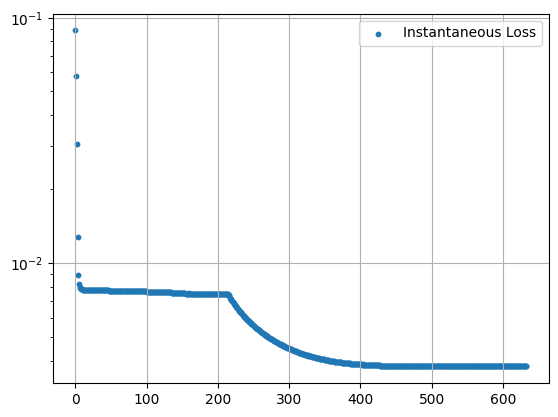

633

In [41]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss"), 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10, label="Instantaneous Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()
plt.close()
Nepochs_losses[-1]

0.003796843673231952 0.0037969210007352547
0.0037971917093705997


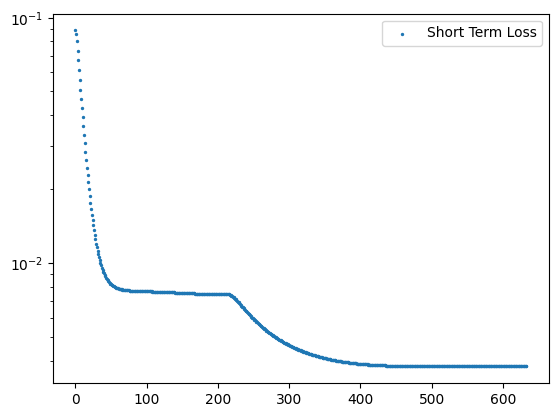

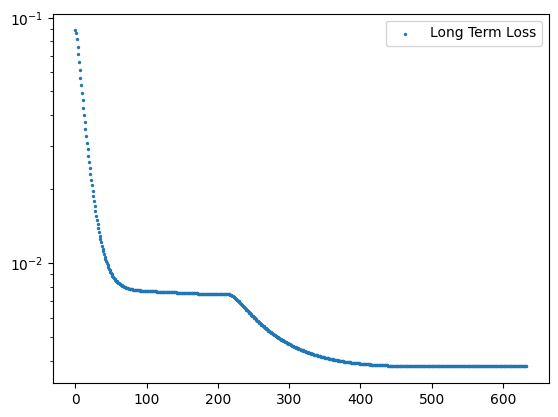

In [42]:
long_term_ema = plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

In [43]:
best_val_loss = long_term_ema[0]
num_bads = 0
for i in range(long_term_ema.shape[0]):
    if num_bads > 50:
        break
    bad = long_term_ema[i] >= best_val_loss *(1.-1e-3)
    if bad:
        num_bads += 1
        print(i, (1-long_term_ema[i]/best_val_loss)*1e3, num_bads)
    else:
        num_bads = 0
        print(i, (1-long_term_ema[i]/best_val_loss)*1e3)
    if long_term_ema[i] < best_val_loss*(1.-1e-3):
        best_val_loss = long_term_ema[i]

0 0.0 1
1 27.631310286440613
2 51.57291205847747
3 67.45813937275157
4 70.59361390286911
5 70.71038698843834
6 70.27392057504977
7 69.6862954607772
8 68.98849024070297
9 68.20598185711246
10 67.36267648252192
11 66.46138989644301
12 65.50623256873922
13 64.49748668748067
14 63.43532019162301
15 62.316738776454386
16 61.146515595909776
17 59.92420997712189
18 58.64770411804876
19 57.32270105359771
20 55.949750594392114
21 54.53045904604592
22 53.06533997758211
23 51.55649238998639
24 50.01464603383366
25 48.44819800314115
26 46.85040949111852
27 45.224561727018056
28 43.58061667577529
29 41.924692304658336
30 40.26589871694553
31 38.60504817415589
32 36.94808266865501
33 35.3034486925905
34 33.675566940552294
35 32.06842923601827
36 30.48851268733732
37 28.936543350023936
38 27.418101458929534
39 25.942765210062223
40 24.510515995591287
41 23.12674796341718
42 21.786575333256785
43 20.496187818947465
44 19.26611907637088
45 18.083487469069514
46 16.959344000547215
47 15.887293939754631


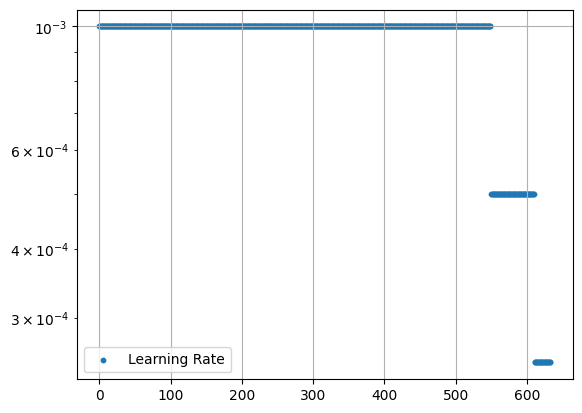

In [44]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss_LR"), 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0
end = -1
plt.scatter(np.arange(LRs.shape[0]),  LRs, s=10, label="Learning Rate")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [69]:
root_score_dir = ""
if "fQuadSin" in config.data_path:
    minx = -1.5
    assert config.sin_space_scale == 25.
    ts_type = "fQuadSin2"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHF2/"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/BiPot/"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    include = (f"{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/SinLog/"
#if not config.stable_target:
#    root_score_dir += "NSTgt/"
maxx = -minx

In [70]:
root_score_dir

'/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/'

In [71]:
def get_drift_files(config, include, ts_type_str, root_score_dir):
    ts_type = f"{ts_type_str}"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "MLP" in file and ts_type in file and include in file and "TSPM" in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file :
                    driftevalexp_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "global" in file:
                    driftoostrack_local_files.append(root_score_dir+file)
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [72]:
NSTgt = "NSTgt" if not config.stable_target else ""
NSTgt += "NFMReg_" if not config.enforce_fourier_mean_reg else ""
if "BiPot" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fBiPot".replace(".", "")
    dirname = "BiPot"
    label = "$\mu_{3}$"
elif "QuadSinHF" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fQuadSinHF".replace(".","")
    dirname = "QuadSinHF2"
    label = "$\mu_{2}$"
elif "SinLog" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fSinLog".replace(".","")
    dirname = "SinLog"
    label = "$\mu_{1}$"
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, include=include, ts_type_str=ts_type_str, root_score_dir=root_score_dir)

In [73]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        elif "SinLog" in config.data_path:
            true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 6)})
    except [FileNotFoundError, pickle.UnpicklingError] as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys())).flatten()
eval_exp_rmses

{1: 3811.718262,
 2: 922.769653,
 3: 168.111938,
 4: 56.18494,
 5: 19.608974,
 6: 6.850064,
 7: 3.896729,
 8: 5.746546,
 9: 1.58775,
 10: 1.56042,
 11: 1.933903,
 12: 1.902593,
 13: 1.701729,
 14: 1.453319,
 15: 1.570965,
 16: 1.413678,
 17: 1.513785,
 18: 1.29421,
 19: 1.279021,
 20: 1.302292,
 21: 1.249361,
 22: 1.27844,
 23: 1.263715,
 24: 1.264453,
 25: 1.149302,
 26: 1.116193,
 27: 1.148734,
 28: 1.128921,
 29: 1.11086,
 30: 1.117015,
 31: 1.165963,
 32: 1.097204,
 33: 1.090509,
 34: 1.050012,
 35: 1.048405,
 36: 1.028925,
 37: 1.061887,
 38: 1.02254,
 39: 1.090768,
 40: 1.035123,
 41: 0.997869,
 42: 0.991471,
 43: 0.988616,
 44: 1.0306,
 45: 0.916775,
 46: 0.895726,
 47: 0.809373,
 48: 0.774069,
 49: 0.723986,
 50: 0.66299,
 51: 0.643639,
 52: 0.551245,
 53: 0.636385,
 54: 0.464884,
 55: 0.401812,
 56: 0.346325,
 57: 0.298369,
 58: 0.241804,
 59: 0.344528,
 60: 0.369142,
 61: 0.192843,
 62: 0.235696,
 63: 0.149069,
 64: 0.172471,
 65: 0.255485,
 66: 0.403304,
 67: 0.150966,
 68: 

In [74]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true, allow_pickle=True)
        all_local_states= np.load(local,allow_pickle=True)
        global_error = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        total_local_errors = np.sqrt(np.mean(global_error.reshape(-1, global_error.shape[-1]), axis=0))
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except pickle.UnpicklingError as e:
        print(e)
        continue
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track= np.array(list(drift_track_rmses.keys())).flatten()
Nepochs_track

array([  1, 100, 200, 300, 400, 500, 600])

In [77]:
common_epochs = np.intersect1d(np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_drifteval), Nepochs_drifteval), np.arange(1, 3500)) #Nepochs_track
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs] # Nepochs_track
track_rmses = np.array(list(eval_exp_rmses.values()))[track_idx] #drift_track_rmses

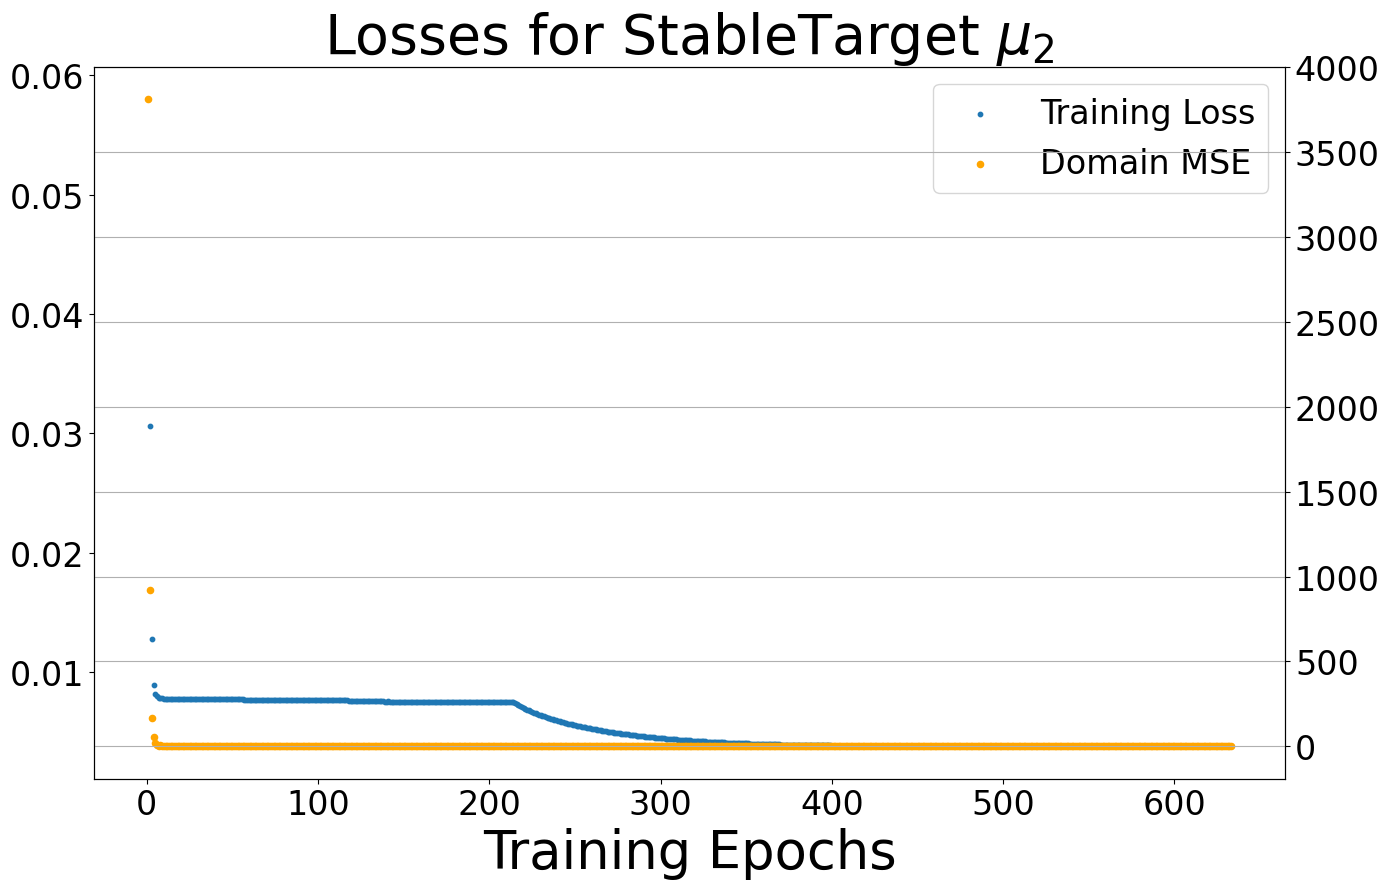

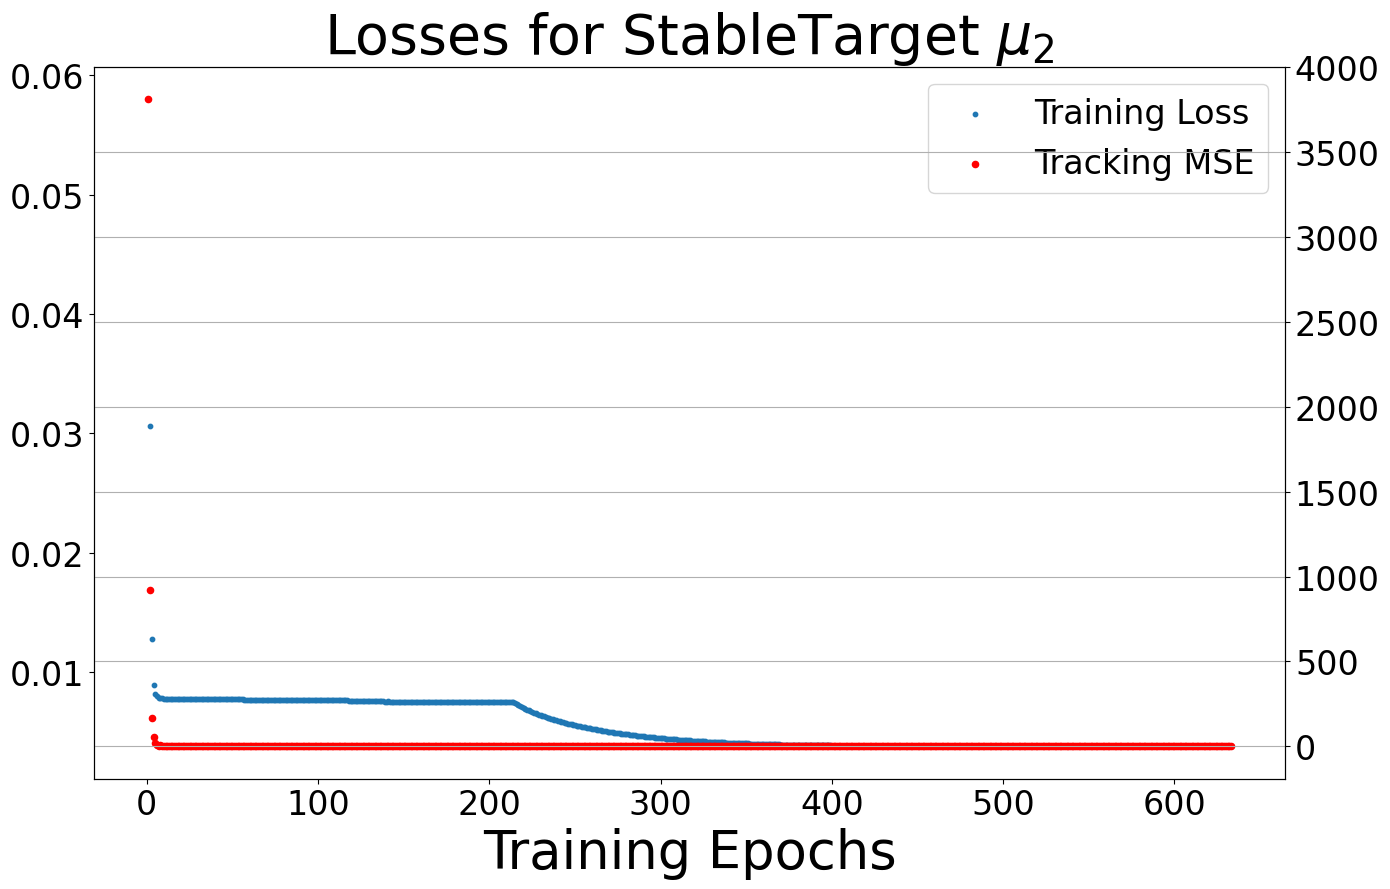

In [78]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()

0.003796843673231952 0.0037969210007352547
0.0037971917093705997


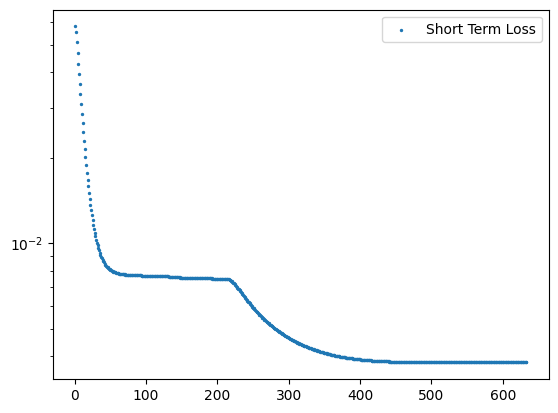

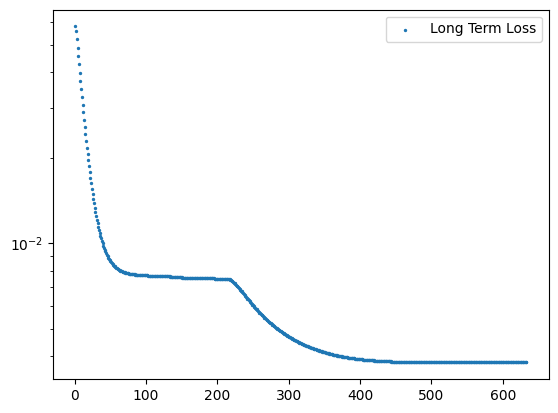

array([0.05797748, 0.05578744, 0.05234886, 0.04887743, 0.04562487,
       0.04261473, 0.03983637, 0.03727603, 0.03491874, 0.03274905,
       0.03075241, 0.02891513, 0.02722453, 0.02566894, 0.02423767,
       0.02292074, 0.02170899, 0.02059409, 0.01956823, 0.01862429,
       0.01775572, 0.01695654, 0.01622128, 0.01554476, 0.01492212,
       0.01434912, 0.01382191, 0.01333681, 0.01289047, 0.01247971,
       0.01210173, 0.0117539 , 0.01143381, 0.01113922, 0.0108681 ,
       0.01061857, 0.01038894, 0.01017764, 0.00998317, 0.00980417,
       0.00963938, 0.0094877 , 0.00934809, 0.0092195 , 0.0091011 ,
       0.008992  , 0.00889149, 0.00879888, 0.00871359, 0.00863505,
       0.00856268, 0.00849597, 0.00843439, 0.00837753, 0.00832508,
       0.0082767 , 0.00823213, 0.00819104, 0.00815312, 0.00811815,
       0.00808581, 0.00805594, 0.00802845, 0.00800317, 0.00797988,
       0.00795837, 0.00793846, 0.00792006, 0.00790299, 0.00788712,
       0.00787251, 0.00785903, 0.00784638, 0.00783472, 0.00782

In [79]:
plot_ewma_losses(epochs=common_epochs, losses=red_losses)

In [ ]:
best_rmse = np.inf
m_mu_hats = []
toSave = False
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    if Nepoch not in common_epochs: continue
    if Nepoch <0: continue
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
        elif "SinLog" in config.data_path:
            true_drifts =  -np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale
        true_drifts = true_drifts.numpy().flatten()
        muhats =  muhats[:, -1, :, 0].reshape(muhats.shape[0], muhats.shape[2]*1)
        mu_hats = muhats.mean(dim=-1) # Pointwise drift estimate
        rmse = rmse_ignore_nans(true_drifts, mu_hats.numpy()).astype(np.float64)
        if rmse < best_rmse:
            print(muhats.shape)
            mu_hats_minq = muhats.quantile(dim=-1, q=0.005).numpy() # Lower bound
            mu_hats_maxq = muhats.quantile(dim=-1, q=0.995).numpy() # Upper boun
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats.numpy(), mean_min=mu_hats_minq, mean_max=mu_hats_maxq, dirname=dirname, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts, Nepoch=Nepoch, label=label)
            print(f"MSE {rmse} at Nepoch {Nepoch}\n")
            print(file)
    except FileNotFoundError as e:
        print(f"{e}, Hi")
#m_mu_hats = torch.Tensor(np.array(m_mu_hats))
#m_mu_hats = m_mu_hats.numpy()
#mu_hats = m_mu_hats.mean(axis=0)


In [ ]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[driftoostrack_true_files, driftoostrack_local_files, common_epochs]):
    Nepoch = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_local_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_local_errors = all_local_errors.reshape(-1, all_local_errors.shape[-1])
        total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
        all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)
        total_local_errors[np.isinf(total_local_errors)] = 0.
        all_errs[np.isinf(all_errs)] = 0.
        total_local_errors_minq, total_local_errors_maxq = np.quantile(all_errs, axis=0,q=[0.005,0.995])
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(f"Pathwise RMSE for Score Estimator for {label}",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('RMSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 7)}_MinIQR_{round(total_local_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
            plt.grid(True)
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at Nepoch {Nepoch}\n")
            print(file)